# Self-Driving Car Advanced Lane Detection

### Libraries

In [117]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


## 1. Camera Calibration

###  Find corners for calibration images

We will go through all the 20 calibration images in ```camera_cal``` directory and find corners in them. The chessboard we use should have **9** corners in x axis and **6** corners in y axis.

In [118]:
corner_x = 9 # number of corners in x axis
corner_y = 6 # number of corners in y axis

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane
gray_shape = None

objp = np.zeros((corner_x * corner_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1, 2)

fnames = glob.glob('camera_cal/calibration*.jpg')
for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_shape = gray.shape
    ret, corners = cv2.findChessboardCorners(gray, (corner_x, corner_y), None)

    if ret:
        cv2.drawChessboardCorners(img, (corner_x, cornor_y), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners)

print('{} images are successfully detected with 9 x 6 corners'.format(len(imgpoints)))

17 images are successfully detected with 9 x 6 corners


### Calibrate Camera
All the ```imgpoints``` we found above will be used to calibrate the camera. The following code will get camera matrix ```mtx``` and distortion cofficient ```dist```. These two parameters will be used to undistort images.

In [119]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape[::-1], None, None)


### Distortion correction

Test undistort function on an example image.

Text(0.5,1,'undistorted image')

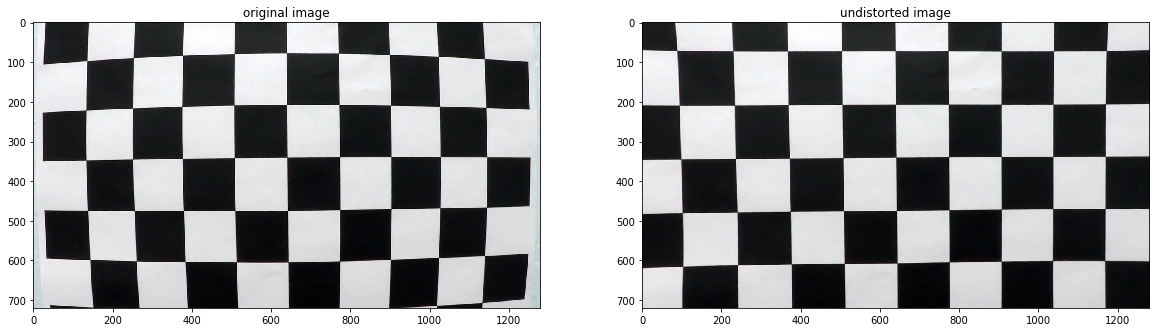

In [120]:
def undistort_img(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

test_img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_img = undistort_img(test_img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('original image')
ax2.imshow(undistorted_img)
ax2.set_title('undistorted image')

## 2. Color/Gradient Threshold

We will use one example image from ```test_images``` directory to demonstrate the color/gradient process.

In [176]:
test_imgs = []
test_img_files = glob.glob('test_images/*.jpg')

for test_img_file in test_img_files:
    test_img = mpimg.imread(test_img_file)
    test_imgs.append(test_img)

# fig, axs = plt.subplots(4, 2, figsize=(10,10))
# for row in range(4):
#     for col in range(2):
#         axs[row, col].imshow(test_imgs[row * col + col])
    

### Saturation in HLS Threshold

In [195]:
def hls_select(img, thresh=(200, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel>thresh[0]) & (s_channel<=thresh[1])] = 1
    return binary_output

hls_imgs = list(map(hls_select, test_imgs))

### Sobel Threshold

In [196]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel=5,  thresh = (30, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel_abs / np.max(sobel_abs))
    
    binary_output = np.zeros_like(sobel_scaled)
    binary_output[ (sobel_scaled > thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    return binary_output

sobel_imgs = list(map(abs_sobel_thresh, test_imgs))    

### Combined Color-Gradient Threshold

In [197]:
def color_sobel_thresh(img):
    bianry_hls = hls_select(img)
    binary_sobel = abs_sobel_thresh(img)
    
    binary_output = np.zeros_like(img[:,:,1])
    binary_output[(bianry_hls == 1) | (binary_sobel == 1)] = 1
    return binary_output

color_sobel_imgs = list(map(color_sobel_thresh, test_imgs))


### Show Processed Result

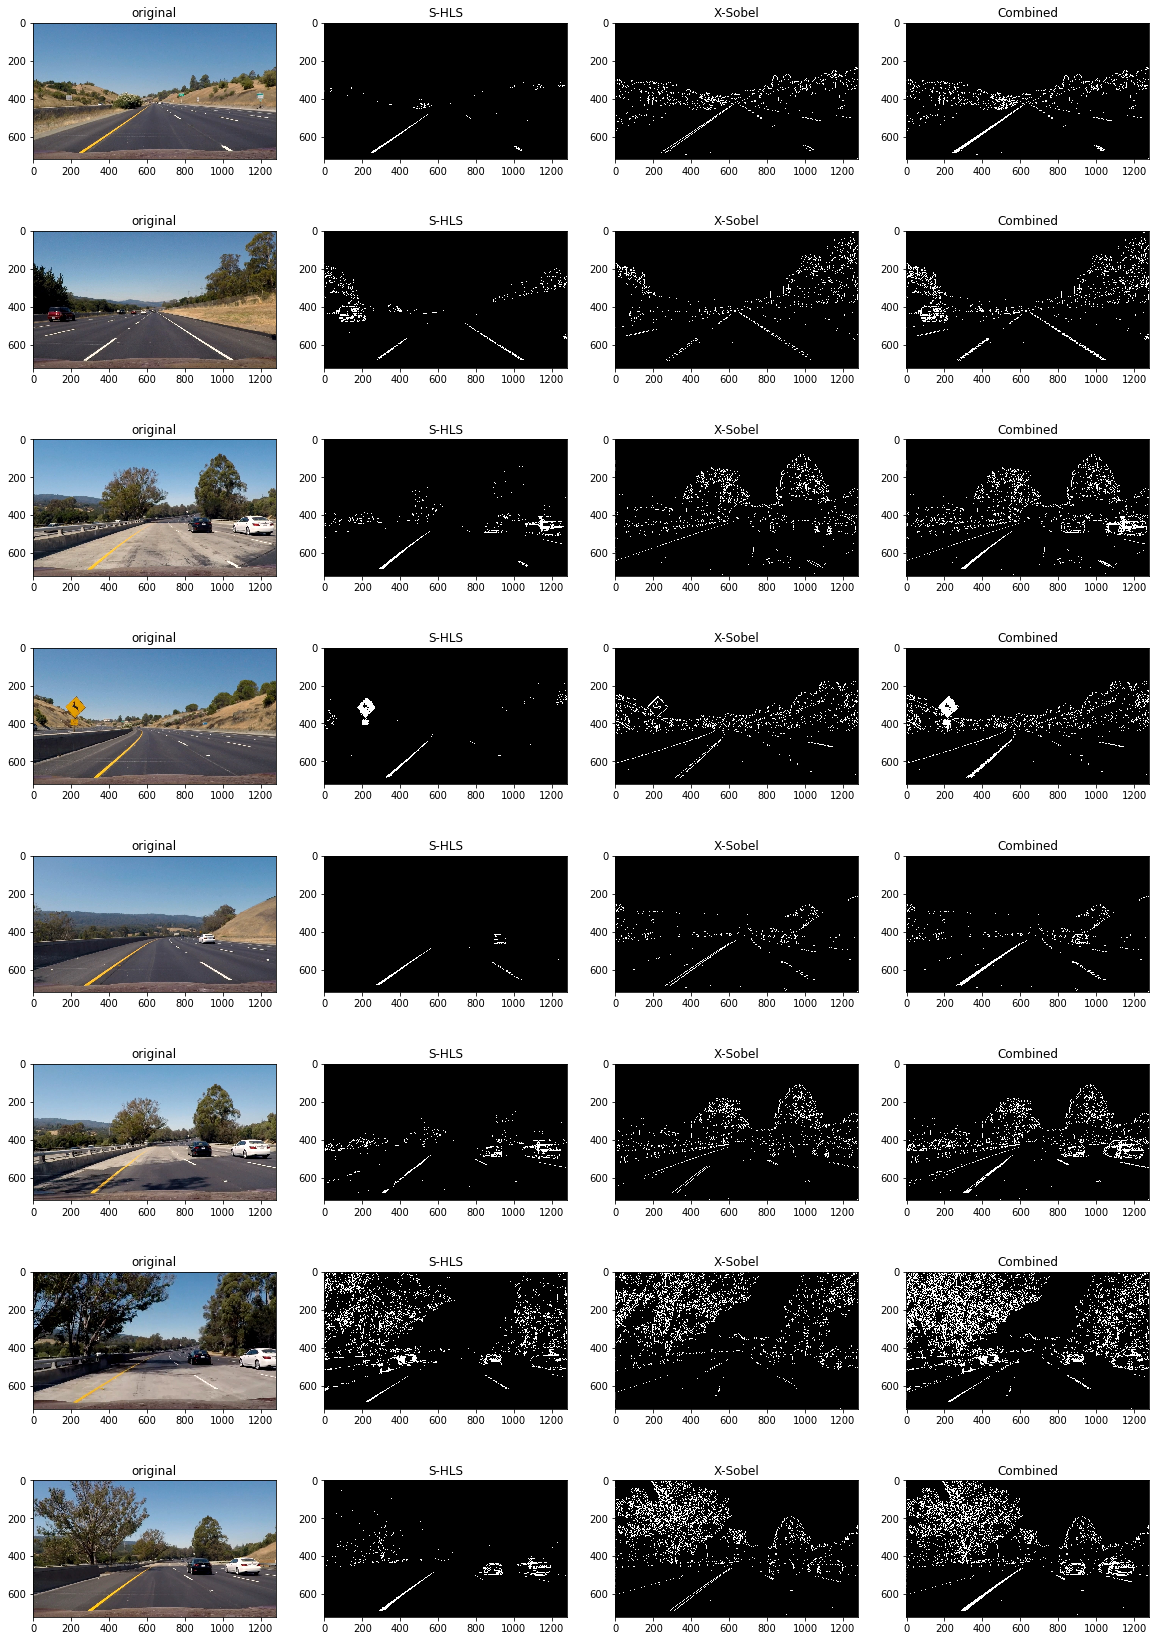

In [198]:
fig, axs = plt.subplots(8, 4, figsize=(20,30))
for row in range(8):
        axs[row, 0].imshow(test_imgs[row])
        axs[row, 0].set_title('original')
        
        axs[row, 1].imshow(hls_imgs[row], cmap='gray')
        axs[row, 1].set_title('S-HLS')

        
        axs[row, 2].imshow(sobel_imgs[row], cmap='gray')
        axs[row, 2].set_title('X-Sobel')

        
        axs[row, 3].imshow(color_sobel_imgs[row], cmap='gray')
        axs[row, 3].set_title('Combined')

## 3. Perspective Transform

To perform perspective transform, we will use an image with straight lines and pick 4 points.

Text(0.5,1,'Perspective Transformed Image')

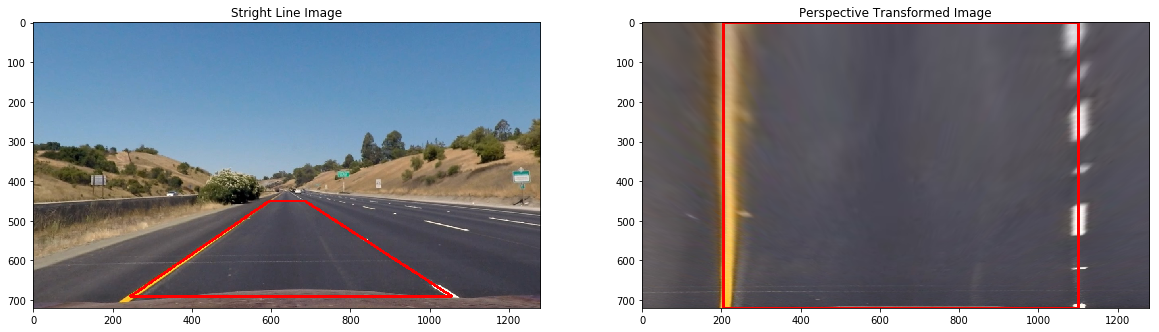

In [281]:
straight_line_img = mpimg.imread('test_images/straight_lines1.jpg')
straight_line_img = undistort_img(straight_line_img)
straight_line_img_copy = np.copy(straight_line_img)

# Find 4 source points in original image.
height, width = straight_line_img.shape[:2]
src_verticles = np.array([
    [
        (245, height-30), 
        (width/2 - 45, 450), 
        (width/2 + 45, 450), 
        (width-225, height-30)
    ]
], dtype=np.int32)
cv2.polylines(straight_line_img_copy, src_verticles, isClosed = True, color = (255,), thickness=5)

# Define new points in new image.
dst_verticles = np.array([
    [
        (205, height),
        (205, 0),
        (width-180, 0),
        (width-180, height)
    ]
], dtype=np.int32)

# Get perspective transform M and Minv
M = cv2.getPerspectiveTransform(src_verticles.astype(np.float32), dst_verticles.astype(np.float32))
Minv = cv2.getPerspectiveTransform(dst_verticles.astype(np.float32), src_verticles.astype(np.float32))

def perspective_transform(img):
    transformed_img = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return transformed_img

transformed_img = perspective_transform(straight_line_img)    
cv2.polylines(transformed_img, dst_verticles, isClosed = True, color = (255,), thickness=5)


# Show result
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1.imshow(straight_line_img_copy)
ax1.set_title('Stright Line Image')

ax2.imshow(transformed_img)
ax2.set_title('Perspective Transformed Image')


### Test on Curve Line

Text(0.5,1,'Perspective Transformed Image')

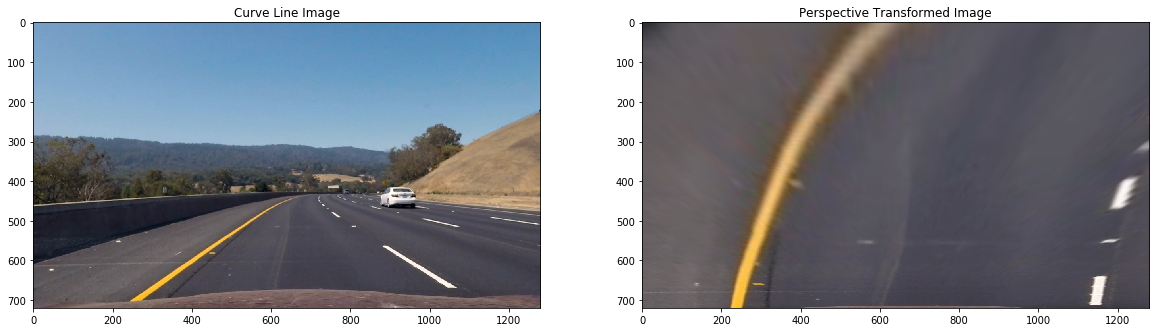

In [280]:
curve_line_img = mpimg.imread('test_images/test3.jpg')
curve_line_img = undistort_img(curve_line_img)
transformed_img = perspective_transform(curve_line_img)

# Show result
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1.imshow(curve_line_img)
ax1.set_title('Curve Line Image')

ax2.imshow(transformed_img)
ax2.set_title('Perspective Transformed Image')

## 4. Fit Lines

Text(0.5,1,'Perspective Transformed Image')

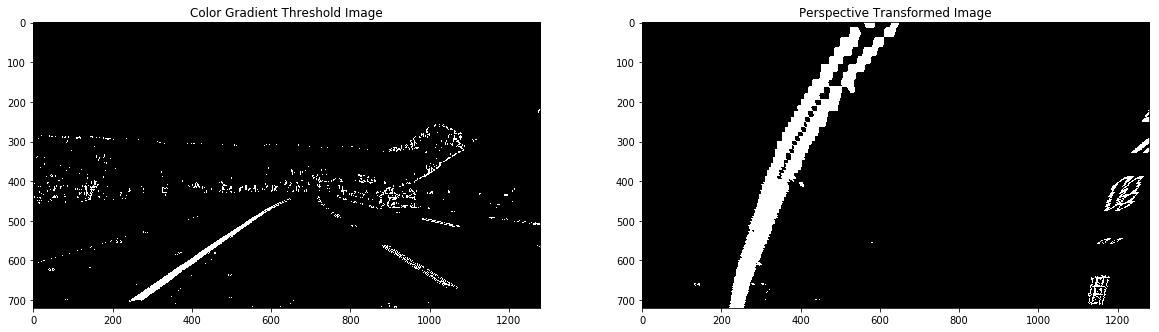

In [290]:
curve_line_img = mpimg.imread('test_images/test3.jpg')
curve_line_img = undistort_img(curve_line_img)
color_gradient_img = color_sobel_thresh(curve_line_img)

transformed_img = perspective_transform(color_gradient_img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1.imshow(color_gradient_img, cmap= 'gray')
ax1.set_title('Color Gradient Threshold Image')

ax2.imshow(transformed_img, cmap= 'gray')
ax2.set_title('Perspective Transformed Image')

In [355]:
def find_left_right_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    cv2.polylines(out_img, 
                  np.dstack((left_fitx, ploty)).reshape(1, -1, 2).astype(np.int32), 
                  isClosed =False, 
                  color=(255,255,0),
                  thickness=5)
    cv2.polylines(out_img, 
                  np.dstack((right_fitx, ploty)).reshape(1, -1, 2).astype(np.int32), 
                  isClosed =False, 
                  color=(255,255,0),
                  thickness=5)
    # Draw fitted window
    window_img = np.zeros_like(out_img)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return (left_fit, right_fit, result_img)

Text(0.5,1,'Fitted Lines')

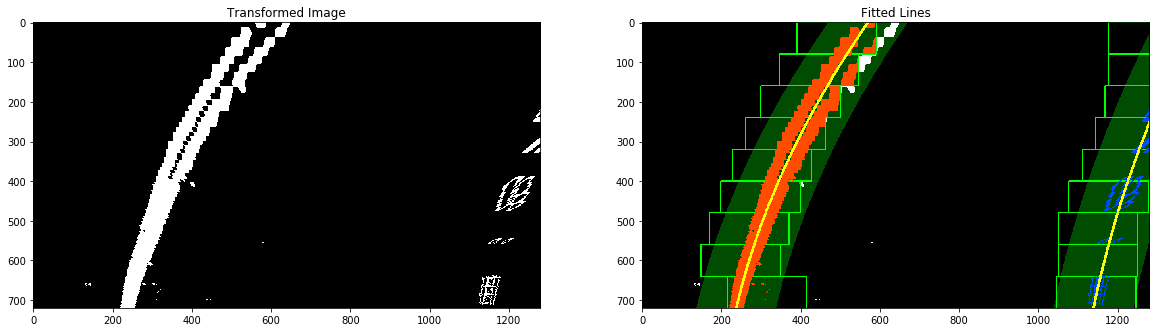

In [356]:
left_fit, right_fit, out_img = find_left_right_lines(transformed_img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1.imshow(transformed_img, cmap= 'gray')
ax1.set_title('Transformed Image')

ax2.imshow(out_img)
ax2.set_title('Fitted Lines')